In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [3]:
BASE_DIR = '..'
COUNTRY = 'malawi_2016'
RANDOM_SEED = 7
COUNTRY_DIR = os.path.join(BASE_DIR, 'countries', COUNTRY)
PROCESSED_DIR = os.path.join(COUNTRY_DIR, 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')

# these relate to the current country in question
IMAGE_DIR = os.path.join(COUNTRY_DIR, 'images')
RESULTS_DIR = os.path.join(COUNTRY_DIR, 'results')
CNN_SAVE_FEATS_DIR = os.path.join(RESULTS_DIR, 'cnn')

In [4]:
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CNN_SAVE_FEATS_DIR, exist_ok=True)

# Feature extract with CNN
If you have run this step before, you can skip it and run the commented out code in the next section to quick-start.

In [5]:
df_images = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [6]:
df_images.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights,nightlights_bin,image_name
0,-17.075000,35.183332,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.1833324726.png
1,-17.058333,35.191666,-17.09515,35.217213,1.477796,0.0,1,-17.058332965100007_35.191665805900016.png
2,-17.075000,35.191666,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.191665805900016.png
3,-17.125000,35.199999,-17.09515,35.217213,1.477796,0.0,1,-17.124999631500014_35.1999991392.png
4,-17.075000,35.208332,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.208332472500025.png


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(os.path.join(MODEL_DIR, 'trained_vgg.pt'), map_location=device)

Using cpu as backend


In [8]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=256, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=3, bias=True)
)

In [9]:
# rip off the final layers
model.classifier = model.classifier[:4]

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=256, bias=True)
)

In [11]:
transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# custom dataset for fast image loading and processing
class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]

        # Load image
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        
        # dataloaders need to return a label, but for the forward pass we don't really care
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:,:,:3]
        im = self.transformer(im)
        return im

dataset = ForwardPassDataset(IMAGE_DIR, transformer)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)
image_order = dataset.image_list


In [12]:
unique_ims = pd.DataFrame.from_dict({'image_name': image_order})
unique_ims.shape

(20768, 1)

In [13]:
feats = np.zeros((unique_ims.shape[0],256))

## Forward Pass

In [17]:
model.eval()

i = 0
# Iterate over data.
for inputs, _ in tqdm(dataloader):
    inputs = inputs.to(device)
    outputs = model(inputs)
    feats[i:i+len(inputs),:] = outputs.cpu().detach().numpy()
    i += len(inputs)


  8%|██▊                                  | 195/2596 [25:44<5:02:26,  7.56s/it]


 15%|█████▌                               | 391/2596 [50:34<4:29:13,  7.33s/it]


 23%|███████▉                           | 587/2596 [1:14:19<4:03:13,  7.26s/it]


 30%|██████████▌                        | 783/2596 [1:38:52<3:49:08,  7.58s/it]


 38%|█████████████▏                     | 979/2596 [2:02:49<3:10:53,  7.08s/it]


 45%|███████████████▍                  | 1175/2596 [2:26:07<2:48:42,  7.12s/it]


 53%|█████████████████▉                | 1371/2596 [2:49:27<2:26:10,  7.16s/it]


 60%|████████████████████▌             | 1567/2596 [3:12:57<2:04:00,  7.23s/it]


 68%|███████████████████████           | 1763/2596 [3:36:54<1:47:37,  7.75s/it]


 75%|█████████████████████████▋        | 1959/2596 [4:01:51<1:18:49,  7.42s/it]


 83%|█████████████████████████████▉      | 2155/2596 [4:25:06<52:03,  7.08s/it]


 91%|████████████████████████████████▌   | 2351/2596 [4:54:51<32:11,  7.89s/it]


 98%|███████████████████████████████████▎| 2547/2596 [5:23:48<06:35,  8.07s/it]


100%|████████████████████████████████████| 2596/2596 [5:29:45<00:00,  7.25s/it]


In [18]:
np.save(os.path.join(CNN_SAVE_FEATS_DIR, 'vgg_forward_feats.npy'), feats)

In [19]:
unique_ims = unique_ims[['image_name']]
# this will be joined with the main df to show what index you should be looking at in feats
unique_ims['feat_index'] = np.arange(len(unique_ims))

In [20]:
unique_ims.head()

,image_name,feat_index
0,-10.008332993300016_33.4416658129.png,0
1,-10.008332993300016_33.466665812800024.png,1
2,-10.008332993300016_33.474999146100004.png,2
3,-10.008332993300016_33.491665812700006.png,3
4,-10.008332993300016_33.5166658126.png,4


In [16]:
df_consumption = pd.merge(left=df_images, right=unique_ims, on='image_name')

In [17]:
df_consumption.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights,nightlights_bin,image_name
0,-17.075000,35.183332,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.1833324726.png
1,-17.058333,35.191666,-17.09515,35.217213,1.477796,0.0,1,-17.058332965100007_35.191665805900016.png
2,-17.075000,35.191666,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.191665805900016.png
3,-17.125000,35.199999,-17.09515,35.217213,1.477796,0.0,1,-17.124999631500014_35.1999991392.png
4,-17.075000,35.208332,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.208332472500025.png


In [18]:
df_consumption.shape

(37368, 8)

In [19]:
group = df_consumption.groupby(['cluster_lat', 'cluster_lon'])
num_clusts = len(group)
num_clusts

780

## Aggregate Features

In [16]:
x = np.zeros((num_clusts, 256))
y = []
clusters = []

NameError: name 'num_clusts' is not defined

In [17]:
# this goes through each cluster group and finds all images that are in the cluster
# it aggregates the features for those images across the cluster
for i, g in enumerate(group):
    lat, long = g[0]
    im_sub = df_consumption[(df_consumption['cluster_lat'] == lat) & (df_consumption['cluster_lon'] == long)].reset_index(drop=True)
    agg_feats = np.zeros((len(im_sub), 256))
    for j, d in im_sub.iterrows():
        agg_feats[j,:] = feats[d.feat_index]
    agg_feats = agg_feats.mean(axis=0) # averages the features across all images in the cluster
    
    x[i,:] = agg_feats
    y.append(g[1]['cons_pc'].values[0])
    clusters.append([lat, long])

NameError: name 'group' is not defined

In [18]:
feats

NameError: name 'feats' is not defined

In [23]:
np.save(os.path.join(CNN_SAVE_FEATS_DIR, 'vgg_cluster_feats.npy'), x)
pickle.dump(clusters, open(os.path.join(CNN_SAVE_FEATS_DIR, 'vgg_cluster_order.pkl'), 'wb'))

NameError: name 'x' is not defined

# Predict Consumption

In [24]:
''' uncomment this to load saved features and start from here '''

def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon']):
    """
         Allows two dataframes to be merged on lat/lon
         Necessary because pandas has trouble merging on floats
    """
    df1 = df1.copy()
    df2 = df2.copy()
   
    # must use ints for merging, as floats induce errors
    df1['merge_lat'] = (10000 * df1[keys[0]]).astype(int)
    df1['merge_lon'] = (10000 * df1[keys[1]]).astype(int)
    
    df2['merge_lat'] = (10000 * df2[keys[0]]).astype(int)
    df2['merge_lon'] = (10000 * df2[keys[1]]).astype(int)
    
    df2.drop(keys, axis=1, inplace=True)
    merged = pd.merge(df1, df2, on=['merge_lat', 'merge_lon'])
    merged.drop(['merge_lat', 'merge_lon'], axis=1, inplace=True)
    return merged

x = np.load(os.path.join(CNN_SAVE_FEATS_DIR, 'vgg_cluster_feats.npy'))
clusters = pickle.load(open(os.path.join(CNN_SAVE_FEATS_DIR, 'vgg_cluster_order.pkl'), 'rb'))
clusters_saved = pd.DataFrame.from_records(clusters, columns=['lat', 'lon'])
clusters_saved['feat_index'] = np.arange(len(clusters_saved))
df_clusters = pd.read_csv(os.path.join(PROCESSED_DIR, 'clusters.csv'))
assert len(df_clusters) == len(clusters_saved)

df = merge_on_lat_lon(df_clusters, clusters_saved, keys=['lat', 'lon'])
assert len(df) == len(df_clusters) == len(clusters_saved)
df.sort_values('feat_index', ascending=True, inplace=True)
y = df['cons_pc'].tolist()


In [25]:
# This is a bunch of code from the Jean et al Github that is modified to work with Python3 and our data

import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns


def predict_consumption(
    X, y, k=5, k_inner=5, points=10,
        alpha_low=1, alpha_high=5, margin=0.25):
    """
    Plots predicted consumption
    """
    np.random.seed(RANDOM_SEED)
    y_hat, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
    return X, y, y_hat, r2


def run_cv(X, y, k, k_inner, points, alpha_low, alpha_high, randomize=False):
    """
    Runs nested cross-validation to make predictions and compute r-squared.
    """
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = np.zeros((k,))
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        r2s, y_hat, fold = evaluate_fold(
            X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
            randomize)
    return y_hat, r2s.mean()


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat


def predict_inner_test_fold(X, y, y_hat, train_idx, test_idx, alpha):
    """
    Predicts inner test fold.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
    return y_hat


def find_best_alpha(X, y, k_inner, alphas):
    """
    Finds the best alpha in an inner CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            y_hat = predict_inner_test_fold(
                X, y, y_hat, train_idx, test_idx, alpha)
        r2 = stats.pearsonr(y, y_hat)[0] ** 2
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    print('best alpha', best_alpha)
    return best_alpha


def evaluate_fold(
    X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
        randomize):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if randomize:
        random.shuffle(y_train)
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    r2s[fold] = r2
    y_hat[test_idx] = y_test_hat
    return r2s, y_hat, fold + 1


In [26]:
y = np.array(y)
y_log = np.log(y)

In [27]:
_, _, y_hat_log, r2 = predict_consumption(x, y_log)
r2

best alpha 10.0
best alpha 10.0
best alpha 10.0
best alpha 10.0
best alpha 10.0


0.4346747994382184

In [28]:
_, _, y_hat, r2 = predict_consumption(x, y)
r2

best alpha 10.0
best alpha 27.825594022071243
best alpha 27.825594022071243
best alpha 10.0
best alpha 10.0


0.3503666576839265

Quick and dirty way of testing:

In [29]:
n_train = int(0.7*(len(x))) # let's use 70% of the data for training
inds = np.arange(len(x))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

train_x = x[train_ind]
valid_x = x[valid_ind]

train_y = y_log[train_ind]
valid_y = y_log[valid_ind]

ss = StandardScaler() # standardize features
train_x = ss.fit_transform(train_x)
valid_x = ss.transform(valid_x)

In [30]:
ridge = linear_model.Ridge(alpha=10) # the best alphas printed suggest using a high alphas
ridge.fit(train_x, train_y)
ridge.score(train_x, train_y)

0.5921576668841427

In [31]:
ridge.score(valid_x, valid_y)

0.447012150421621

Plots:

In [32]:
preds = y_hat_log
valid_y = y_log

Text(0.5, 1.0, 'VGG Feature Quality')

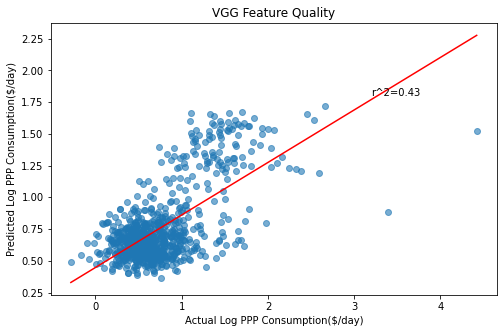

In [33]:
plt.figure(figsize=(8,5))
plt.scatter(valid_y, preds, alpha=0.6)
plt.plot(np.unique(valid_y), np.poly1d(np.polyfit(valid_y, preds, 1))(np.unique(valid_y)), color='r')
plt.text(3.2, 1.8, 'r^2=0.43', size=10)
plt.xlabel('Actual Log PPP Consumption($/day)')
plt.ylabel('Predicted Log PPP Consumption($/day)')
plt.title('VGG Feature Quality')

In [16]:
model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [17]:
from torchsummary import summary

summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]         590,080
      BatchNorm2d-13          [-1, 256, 16, 16]             512
             ReLU-14          [-1, 256,